## Churn Analysis and Prediction

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

from sklearn.feature_selection import RFE, RFECV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve

from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Display all rows and columns of a dataframe 
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Load Data

In [2]:
df = pd.read_csv('Data/Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Exploratory Data Analysis 

In [3]:
# Check datatype and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Convert TotalCharges to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df.TotalCharges.dtype

dtype('float64')

In [5]:
# Get descriptive statistics
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
df.describe(include=['object'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [7]:
# Drop customerID
df = df.drop('customerID', axis=1)

In [8]:
# Plot churn rate distribution
churn_count = df['Churn'].value_counts()

# Create a donut chart 
fig = px.pie(names=churn_count.index, values=churn_count.values, hole=0.6)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    title='Distribution of Churn',
    width=600,
    height=400
)

# Show the chart
fig.show()

27.5% or 1869 customers have churned while 73.5% or 5174 customers have not chured. This is about a 1:2.77 churn to not churn ratio indicating that for every one customer who churned, there are 2.77 customers who did not churn.

In [9]:
# Calculate churn percentage
churn_percentage = churn_count / len(df) * 100

# Create a bar plot
fig = px.bar(x=churn_count.index, y=churn_count.values, text=churn_percentage.round(2), 
             color=churn_count.index)

# Customize the layout
fig.update_traces(texttemplate='%{text}%',textposition='outside')
fig.update_layout(
    title='Distribution of Churn',
    xaxis_title='Churn',
    yaxis_title='Count',
    width=600,
    height=400,
    margin=dict(l=50, r=50, b=50, t=50, pad=4)
)

# Show the plot
fig.show()

In [10]:
# Group the data by gender and chrurn, and count the number of customers in each group
grouped = df.groupby(['gender', 'Churn']).size().reset_index(name='count')

# Calculate the churn rate for each gender
totals = grouped.groupby('gender')['count'].transform('sum')
grouped['churn_rate'] = grouped['count']/totals

# Create bar chart
fig = px.bar(grouped, x='gender', y='churn_rate', color='Churn', text='count',
             barmode='group',
             hover_data={'count': True, 'churn_rate': ':.2%'},
             labels={'count': 'Count', 'churn_rate': 'Churn Rate'})

# Set the chart title and axis labels
fig.update_layout(
    title='Churn Rate by Gender',
    xaxis_title='Gender',
    width=600,
    height=400
)

# Update the y-axis range and format
fig.update_yaxes(range=[0, 1], tickformat='.0%')

# Display the chart
fig.show()

In [11]:
def plot_churn_rate_by_category(category, df):
    # Group the data by the category and churn, and count the number of customers in each group
    grouped = df.groupby([category, 'Churn']).size().reset_index(name='count')

    # Calculate the churn rate for each category
    totals = grouped.groupby(category)['count'].transform('sum')
    grouped['churn_rate'] = grouped['count'] / totals

    # Create the stacked bar chart
    fig = px.bar(grouped, x=category, y='churn_rate', color='Churn', text='count',
                 barmode='group',
                 hover_data={'count': True, 'churn_rate': ':.2%'},
                 labels={'count': 'Count', 'churn_rate': 'Churn Rate'})

    # Set the chart title and axis labels
    fig.update_layout(
        title=f'Churn Rate by {category}',
        xaxis_title=category,
        yaxis_title='Percent',
        width=600,
        height=400
    )

    # Update the y-axis range and format
    fig.update_yaxes(range=[0, 1], tickformat='.0%')

    # Display the chart
    fig.show()


plot_churn_rate_by_category('PaymentMethod', df)
plot_churn_rate_by_category('Partner', df)
plot_churn_rate_by_category('Dependents', df)
plot_churn_rate_by_category('Contract', df)
plot_churn_rate_by_category('InternetService', df)
plot_churn_rate_by_category('SeniorCitizen', df)
plot_churn_rate_by_category('OnlineSecurity', df)
plot_churn_rate_by_category('StreamingMovies', df)
plot_churn_rate_by_category('StreamingTV', df)

In [12]:
# create histograms of tenure grouped by churn
hist = px.histogram(data_frame=df, x='tenure', color='Churn', nbins=50, barmode='overlay',
                    category_orders={'Churn': ['No', 'Yes']}, opacity=0.7)
hist.update_layout(xaxis_title="Tenure", 
                   yaxis_title="Count", 
                   title="Distribution of Tenure by Churn",
                   width=600,
                   height=400)


The majority of customers who have churned have significantly lower tenure than those who have not churned

In [13]:
grouped = df.groupby(['tenure', 'Churn']).size().reset_index(name='count')

# Calculate the churn rate for each gender
totals = grouped.groupby('tenure')['count'].transform('sum')
grouped['churn_rate'] = grouped['count']/totals

# Create a scatter plot of the churn rate against the tenure
fig = px.line(data_frame=grouped, x='tenure', y='churn_rate', color='Churn')

# Add axis labels and title
fig.update_layout(xaxis_title="Tenure",
                yaxis_title="Churn Rate",
                title="Churn Rate by Tenure",
                width=600,
                height=400)

# Show the plot
fig.show()

As Tenure (time with company) increases the churn rate declines.  

In [14]:
# create histograms of tenure and age, grouped by churn
hist = px.histogram(data_frame=df, x='MonthlyCharges', color='Churn', nbins=50, barmode='overlay',
                    category_orders={'Churn': ['No', 'Yes']}, opacity=0.7)
hist.update_layout(xaxis_title="MonthlyCharges", 
                   yaxis_title="Count", 
                   title="Distribution of MonthlyCharges by Churn",
                   width=600,
                   height=400)

In [15]:
# create histograms of tenure and age, grouped by churn
hist = px.histogram(data_frame=df, x='TotalCharges', color='Churn', nbins=50, barmode='overlay',
                    category_orders={'Churn': ['No', 'Yes']}, opacity=0.7)
hist.update_layout(xaxis_title="TotalCharges", 
                   yaxis_title="Count", 
                   title="Distribution of TotalCharges by Churn",
                   width=600,
                   height=400)

In [16]:
# Group the data by gender, partner and churn, and count the number of customers in each group
grouped = df.groupby(['gender', 'Partner', 'Churn']).size().reset_index(name='count')

# Calcualate the churn rate for each gender and partner combination
totals = grouped.groupby(['gender', 'Partner'])['count'].transform('sum')
grouped['churn_rate'] = grouped['count'] / totals

# Create the grouped bar chart
fig = px.bar(grouped, x='Partner', y='churn_rate', color='Churn', text='count',
             barmode='group',
             hover_data={'count': True, 'churn_rate': ':.2%'},
             labels={'Partner': 'Has Partner?', 'count': 'Count', 'churn_rate': 'Churn Rate'},
             facet_col='gender')

# Set the chart title and axis labels
fig.update_layout(
    title='Churn Rate by Gender and Partner Status',
    xaxis_title='Has Partner?',
    yaxis_title='Percent',
    width=800,
    height=400
)

# Update the y-axis range and format
fig.update_yaxes(range=[0, 1], tickformat='.0%')

# Display the chart
fig.show()

In [17]:
def plot_grouped_bar_chart(df, feature1, feature2):
    # Group the data by feature1, feature2, and churn, and count the number of customers in each group
    grouped = df.groupby([feature1, feature2, 'Churn']).size().reset_index(name='count')

    # Calculate the churn rate for each feature1 and feature2 combination
    totals = grouped.groupby([feature1, feature2])['count'].transform('sum')
    grouped['churn_rate'] = grouped['count'] / totals

    # Create the grouped bar chart
    fig = px.bar(grouped, x=feature2, y='churn_rate', color='Churn', text='count',
                barmode='group', color_discrete_sequence=['#636EFA', '#EF553B'],
                hover_data={'count': True, 'churn_rate': ':.2%'},
                labels={feature2: feature2.capitalize(), 'count': 'Count', 'churn_rate': 'Churn Rate'},
                facet_col=feature1)


    # Set the chart title and axis labels
    fig.update_layout(
        title=f'Churn Rate by {feature1.capitalize()} and {feature2.capitalize()}',
        xaxis_title=feature2.capitalize(),
        yaxis_title='Percent',
        width=800,
        height=400
    )

    # Update the y-axis range and format
    fig.update_yaxes(range=[0, 1], tickformat='.0%')

    # Display the chart
    fig.show()

plot_grouped_bar_chart(df, 'Contract', 'PaymentMethod')
plot_grouped_bar_chart(df, 'SeniorCitizen', 'Partner')
plot_grouped_bar_chart(df, 'SeniorCitizen', 'PaymentMethod')
plot_grouped_bar_chart(df, 'InternetService', 'OnlineSecurity')
plot_grouped_bar_chart(df, 'InternetService', 'Contract')
plot_grouped_bar_chart(df, 'PaperlessBilling', 'MultipleLines')
plot_grouped_bar_chart(df, 'TechSupport', 'OnlineSecurity')

### Data Preprocessing

In [18]:
# Re-load data
df = pd.read_csv('Data/Telco-Customer-Churn.csv')

# Drop customerID
customer_ids = df['customerID']
df = df.drop('customerID', axis=1)

# Convert TotalCharges to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Encode 'Churn'
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

# Select features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [19]:
# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.18, random_state=42)

In [20]:
# Create function to preprocess data
def preprocess_data(X_train, X_val, X_test, categorical_features, numerical_features):
    """
    Preprocesses the input data using one-hot encoding for categorical features and standardization for numerical features
    Args:
        X_train: training data
        X_val: validation data
        X_test: test data
        categorical_features: list of categorical feaure names
        numerical_feaures: list of numerical feature names

    Returns:
        X_train_processed_df: preprocessed training data
        X_val_processed_df: preprocessed validation data
        X_test_processed_df: preprocessed test data
    """

    preprocessor = ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)
    ], remainder='passthrough')

    # Fit and transform the data using preprocessing pipeline
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Get the names of the transformed categorical features
    cat_encoder = preprocessor.named_transformers_['onehot']
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

    # Combine the transformed categorical and numerical features into a single list of column names
    all_feature_names = list(cat_feature_names) + numerical_features

    # Create DataFrames for the processed training, validation, and test sets
    X_train_processed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
    X_val_processed_df = pd.DataFrame(X_val_preprocessed, columns=all_feature_names)
    X_test_processed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

    return X_train_processed_df, X_val_processed_df, X_test_processed_df

In [21]:
# Define categorical and numerical features
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 
                        'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                        'StreamingTV', 'StreamingMovies', 'Contract', 
                        'PaperlessBilling', 'PaymentMethod']
numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# Preprocess the data using the preprocessing function
X_train_processed, X_val_processed, X_test_processed = preprocess_data(X_train, X_val, X_test, categorical_features, numerical_features)


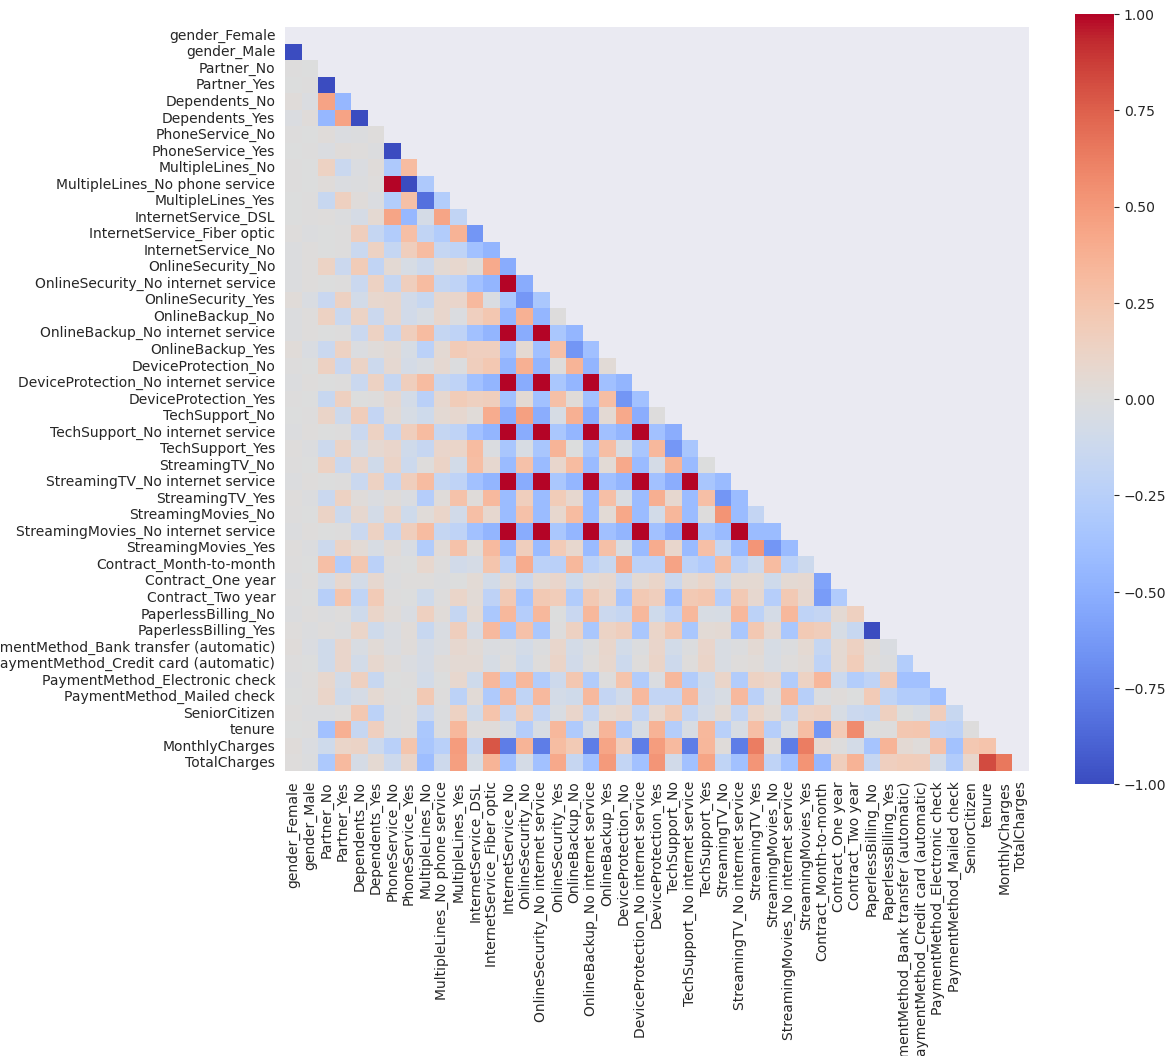

In [22]:
# Check linear correlation (rho) between individual feautures and the target variable
corr = X_train_processed.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(corr, mask=mask, square=True, cmap='coolwarm', annot=False, vmin=-1, vmax=1)

### Model Training and Experimentation

In [23]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train_processed, X_val_processed, y_train, y_val)
models.sort_values(by='Accuracy', ascending=False)


100%|██████████| 29/29 [00:06<00:00,  4.53it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.81,0.72,0.72,0.80,0.03
SVC,0.81,0.71,0.71,0.80,0.59
AdaBoostClassifier,0.80,0.71,0.71,0.80,0.19
CalibratedClassifierCV,0.80,0.71,0.71,0.79,1.54
LinearSVC,0.80,0.70,0.70,0.79,0.38
NuSVC,0.80,0.67,0.67,0.78,0.70
RidgeClassifier,0.80,0.70,0.70,0.79,0.01
RidgeClassifierCV,0.80,0.69,0.69,0.79,0.03
LinearDiscriminantAnalysis,0.79,0.70,0.70,0.79,0.03


In [24]:
# Create dictionary of models from the results produced by LazyClassifier
models = {
    "SVC": SVC(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(), 
    "ExtraTreesClassifier": ExtraTreesClassifier(), 
    "LGBMClassifier": LGBMClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(), 
    "RidgeClassifierCV": RidgeClassifierCV(),
    "AdaboostClassifier": AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier()
    
}

In [25]:
# Create list to store model names, accuracy and roc_auc score results
model_names, model_acc_results, model_roc_results = [], [], []

# Loop through dictionary and train models
for name, model in models.items():
    history = model.fit(X_train_processed, y_train)
    preds = history.predict(X_val_processed)
    score = accuracy_score(y_val, preds)
    roc = roc_auc_score(y_val, preds)
    model_acc_results.append(score)
    model_roc_results.append(roc)
    model_names.append(name)

    # Create dataframe and print reults
    df_results = pd.DataFrame([model_names, model_acc_results, model_roc_results])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: 'Model', 1: 'Accuracy', 2: 'ROC AUC'}).sort_values(by='Accuracy', ascending=False)

df_results
    

,Model,Accuracy,ROC AUC
0,SVC,0.81,0.70
1,LogisticRegression,0.81,0.72
10,AdaboostClassifier,0.80,0.71
9,RidgeClassifierCV,0.80,0.69
6,LGBMClassifier,0.79,0.70
2,RandomForestClassifier,0.78,0.68
11,XGBClassifier,0.78,0.70
5,ExtraTreesClassifier,0.76,0.66
8,KNeighborsClassifier,0.75,0.68
7,DecisionTreeClassifier,0.73,0.65


### Hyperparameter Tuning

In [26]:
# Create function for Performance Evaluation
def evaluate_performance(model, X, y, dataset_name):
    """
    Evaluates the performance of a given model on the input data
    
    Args:
        model: trained machine learning model
        X: input data
        y: target labels
        dataset_name: name of the dataset

    Returns:
        accuracy: accuracy score
        recall: recall score
        precision: precision score
        f1: F1 score
        roc_auc: roc auc score
    """
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    print("{} Accuracy: {:.4f}".format(dataset_name, accuracy))
    print("{} Recall: {:.4f}".format(dataset_name, recall))
    print("{} Precision: {:.4f}".format(dataset_name, precision))
    print("{} F1 score: {:.4f}".format(dataset_name, f1))
    print("{} ROC AUC score: {:.4f}".format(dataset_name, roc_auc))
    print(confusion_matrix(y, y_pred))
    print(classification_report(y, y_pred))
    return accuracy, recall, precision, f1, roc_auc

#### Support Vector Classifier (SVC)

In [27]:
# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create a GridSearchCV object with the SVC model and the parameter grid
svc_grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)


# Fit the grid search object to the preprocessed training data
svc_grid_search.fit(X_train_processed, y_train)

# Print the best hyperparamters and the corresponding validation score
print("Best hyperparameters: ", svc_grid_search.best_params_)
print(f"Validation Score: {svc_grid_search.best_score_}")

svc_best_model = SVC(**svc_grid_search.best_params_)
svc_best_model.fit(X_train_processed, y_train)

evaluate_performance(svc_best_model, X_val_processed, y_val, "Validation set")

Best hyperparameters:  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Validation Score: 0.7980862455908702
Validation set Accuracy: 0.8071
Validation set Recall: 0.4781
Validation set Precision: 0.6684
Validation set F1 score: 0.5574
Validation set ROC AUC score: 0.6986
[[739  65]
 [143 131]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       804
           1       0.67      0.48      0.56       274

    accuracy                           0.81      1078
   macro avg       0.75      0.70      0.72      1078
weighted avg       0.79      0.81      0.80      1078



(0.8070500927643784,
 0.4781021897810219,
 0.6683673469387755,
 0.5574468085106383,
 0.6986282093183716)

#### RidgeClassifierCV

In [28]:
# Define the range of hyperparameters to search
param_grid = {
    'alphas': [(0.01, 0.1, 1.0), (0.1, 1.0, 10.0), (1.0, 10.0, 100.0)],
    'fit_intercept': [True, False]
}

# Create a RidgeClassifierCV object
rcv = RidgeClassifierCV()

# Create a GridSearchCV object
ridge_grid_search = GridSearchCV(rcv, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
ridge_grid_search.fit(X_train_processed, y_train)

# print the best hyperparameters and the corresponding validation score
print("Best hyperparameters: ", ridge_grid_search.best_params_)
print("Validation score: ", ridge_grid_search.best_score_)


ridge_model_best = RidgeClassifierCV(**ridge_grid_search.best_params_)
ridge_model_best.fit(X_train_processed, y_train)

# evaluate the performance of the model on the validation and test sets
evaluate_performance(ridge_model_best, X_val_processed, y_val, "Validation set")

Best hyperparameters:  {'alphas': (1.0, 10.0, 100.0), 'fit_intercept': False}
Validation score:  0.7984927471240744
Validation set Accuracy: 0.7968
Validation set Recall: 0.4854
Validation set Precision: 0.6303
Validation set F1 score: 0.5485
Validation set ROC AUC score: 0.6942
[[726  78]
 [141 133]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       804
           1       0.63      0.49      0.55       274

    accuracy                           0.80      1078
   macro avg       0.73      0.69      0.71      1078
weighted avg       0.78      0.80      0.79      1078



(0.7968460111317254,
 0.4854014598540146,
 0.6303317535545023,
 0.5484536082474226,
 0.6941932672404402)

#### LogisticRegression

In [29]:
# define parameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 500, 1000]}

# create Logistic Regression object
lr = LogisticRegression()

# create grid search object
lr_grid_search = GridSearchCV(lr, param_grid=param_grid, cv=5, n_jobs=-1)

# fit grid search object to the data
lr_grid_search.fit(X_train_processed, y_train)



# print the best hyperparameters and the corresponding validation score
print("Best hyperparameters: ", lr_grid_search.best_params_)
print("Validation score: ", lr_grid_search.best_score_)


log_model_best = LogisticRegression(**lr_grid_search.best_params_)
log_model_best.fit(X_train_processed, y_train)

# evaluate the performance of the model on the validation and test sets
evaluate_performance(log_model_best, X_val_processed, y_val, "Validation set")

/Users/jacob/miniforge3/envs/mlenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jacob/miniforge3/envs/mlenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jacob/miniforge3/envs/mlenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jacob/miniforge3/envs/mlenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jacob/miniforge3/envs/mlenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jac

Best hyperparameters:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Validation score:  0.8021614338417716
Validation set Accuracy: 0.8052
Validation set Recall: 0.5438
Validation set Precision: 0.6368
Validation set F1 score: 0.5866
Validation set ROC AUC score: 0.7190
[[719  85]
 [125 149]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       804
           1       0.64      0.54      0.59       274

    accuracy                           0.81      1078
   macro avg       0.74      0.72      0.73      1078
weighted avg       0.80      0.81      0.80      1078



(0.8051948051948052,
 0.5437956204379562,
 0.6367521367521367,
 0.5866141732283464,
 0.7190371137015651)

#### AdaBoostClassifier

In [30]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'base_estimator': [DecisionTreeClassifier(max_depth=1), 
                       DecisionTreeClassifier(max_depth=2)]}

ada = AdaBoostClassifier()

ada_grid_search = GridSearchCV(ada, param_grid, cv=5)
ada_grid_search.fit(X_train_processed, y_train)

# print the best hyperparameters and the corresponding validation score
print("Best hyperparameters: ", ada_grid_search.best_params_)
print("Validation score: ", ada_grid_search.best_score_)


ada_model_best = AdaBoostClassifier(**ada_grid_search.best_params_)
ada_model_best.fit(X_train_processed, y_train)

# evaluate the performance of the model on the validation and test sets
evaluate_performance(ada_model_best, X_val_processed, y_val, "Validation set")


Best hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.1, 'n_estimators': 200}
Validation score:  0.8023653074401407
Validation set Accuracy: 0.8043
Validation set Recall: 0.5255
Validation set Precision: 0.6400
Validation set F1 score: 0.5772
Validation set ROC AUC score: 0.7124
[[723  81]
 [130 144]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       804
           1       0.64      0.53      0.58       274

    accuracy                           0.80      1078
   macro avg       0.74      0.71      0.72      1078
weighted avg       0.79      0.80      0.80      1078



(0.8042671614100185,
 0.5255474452554745,
 0.64,
 0.5771543086172346,
 0.712400588299379)

#### XGBoostClassifier


In [31]:
# Fefine parameter grid for grid search
param_grid = {
    'max_depth': [3, 4, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 500],
}


# create an XGBoost classifier
xgb_model = XGBClassifier()

# perform grid search to find the best hyperparameters
xgb_grid_search = GridSearchCV(xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)
xgb_grid_search.fit(X_train_processed, y_train)

# print the best hyperparameters and score
print("Best parameters:", xgb_grid_search.best_params_)
print("Best score:", xgb_grid_search.best_score_)

# train an XGBoost model using the preprocessed data and the best hyperparameters
xgb_model_best = XGBClassifier(**xgb_grid_search.best_params_)
xgb_model_best.fit(X_train_processed, y_train)

# evaluate the performance of the model on the validation and test sets
evaluate_performance(xgb_model_best, X_val_processed, y_val, "Validation set")

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best score: 0.8039962962270927
Validation set Accuracy: 0.8108
Validation set Recall: 0.5401
Validation set Precision: 0.6549
Validation set F1 score: 0.5920
Validation set ROC AUC score: 0.7216
[[726  78]
 [126 148]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       804
           1       0.65      0.54      0.59       274

    accuracy                           0.81      1078
   macro avg       0.75      0.72      0.73      1078
weighted avg       0.80      0.81      0.80      1078



(0.8107606679035251,
 0.5401459854014599,
 0.6548672566371682,
 0.592,
 0.7215655300141628)

### Model Interpretation

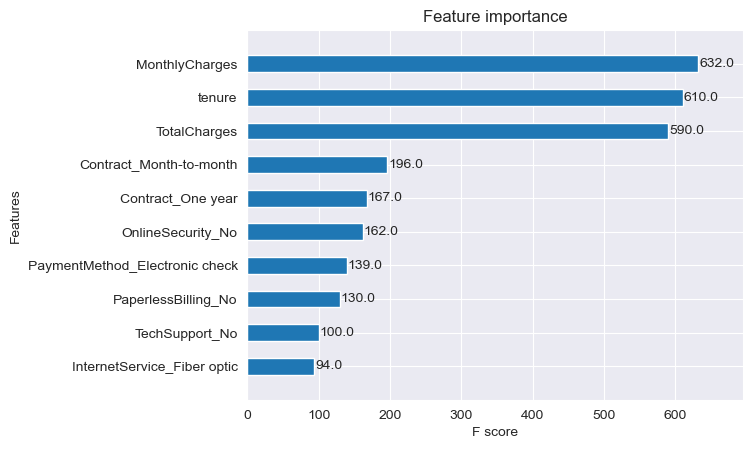

In [32]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
sns.set_style("darkgrid")
plot_importance(xgb_model_best, height=0.5, max_num_features=10)
plt.show()

From our plot_importances results we can see that are top three most important features are MonthlyCharges, tenure, and TotalCharges. Each of the features has an F Score about 3x greater than the 4th ranked feaured Contract_Month-to-Month

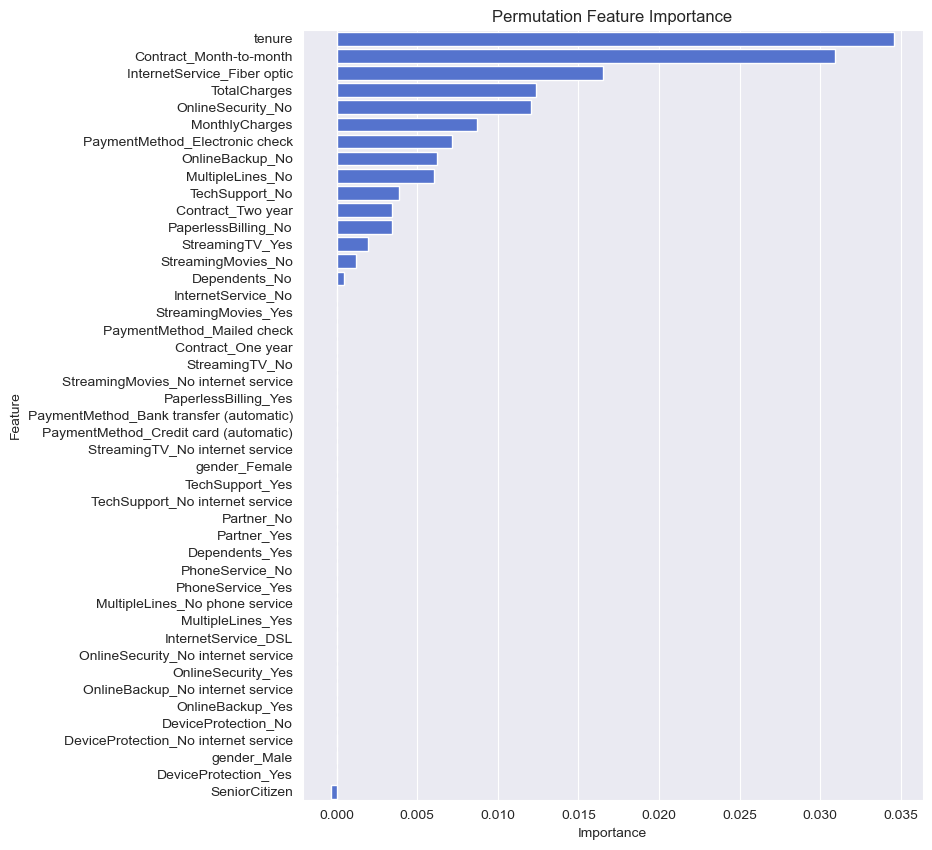

In [33]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
results = permutation_importance(xgb_model_best, X_val_processed, y_val, n_repeats=10, random_state=42)

# Create a DataFrame for the feature importances
importance_df = pd.DataFrame({'Feature': X_val_processed.columns, 'Importance': results.importances_mean})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
fig, ax = plt.subplots(figsize=(8, 10))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='royalblue')

# Set the title and axis labels
ax.set_title('Permutation Feature Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

plt.show()

In [34]:
import lime
import lime.lime_tabular

# create the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_processed.values, feature_names=X_train_processed.columns)

# explain the prediction for the first test instance
exp = explainer.explain_instance(X_test_processed.iloc[0], xgb_model_best.predict_proba)

# print the explanation
print(exp.as_list())


[('0.00 < Contract_Month-to-month <= 1.00', 0.19127933747941245), ('tenure <= -0.96', 0.09585168724259024), ('InternetService_Fiber optic <= 0.00', -0.0639695238059164), ('0.00 < OnlineSecurity_No <= 1.00', 0.0567205403408788), ('TotalCharges <= -0.84', 0.04900204154375302), ('Contract_Two year <= 0.00', 0.04731576746152953), ('0.00 < TechSupport_No <= 1.00', 0.045843501935357564), ('MonthlyCharges <= -0.89', -0.03991873909200718), ('0.00 < PaymentMethod_Electronic check <= 1.00', 0.03553406457558497), ('PaperlessBilling_No <= 0.00', 0.029165435052148782)]


From the Lime results, we can see that the top three most important features for the prediction are Contract_Month-to-month, tenure, and InternetService_Fiber optic. This suggests that customers with a month-to-month contract and a shorter tenure, and those who use fiber optic internet service are more likely to churn. On the other hand, customers with a two-year contract and those who do not use electronic check as their payment method are more likely to stay.

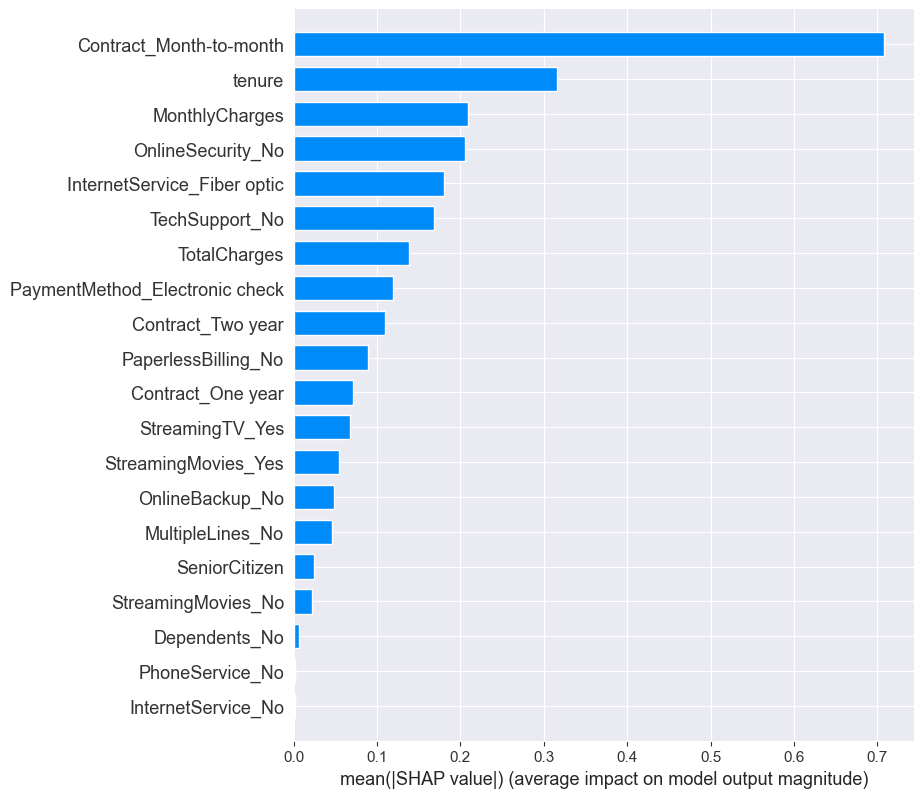

In [35]:
import shap
shap.initjs()

# calculate the SHAP values
explainer = shap.Explainer(xgb_model_best)
shap_values = explainer(X_test_processed)

# plot the SHAP summary plot
shap.summary_plot(shap_values, X_val_processed, plot_type="bar")

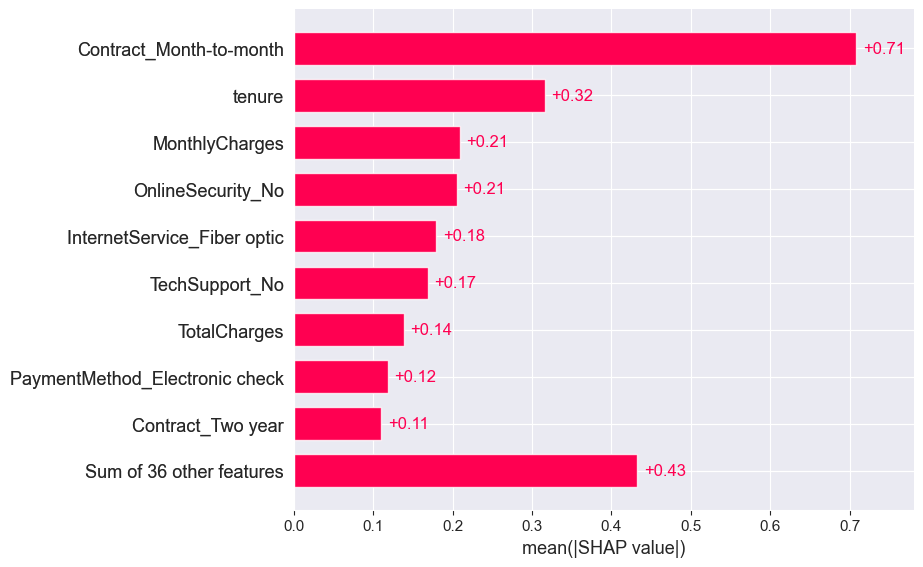

In [36]:
# Mean SHAP
shap.plots.bar(shap_values)

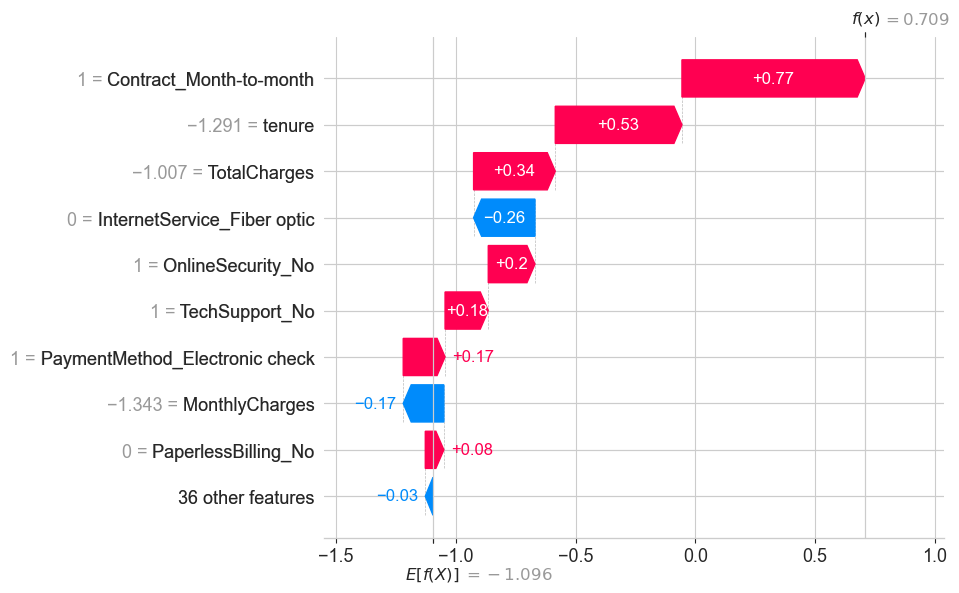

In [77]:
# plot the SHAP values
shap.plots.waterfall(shap_values[0])


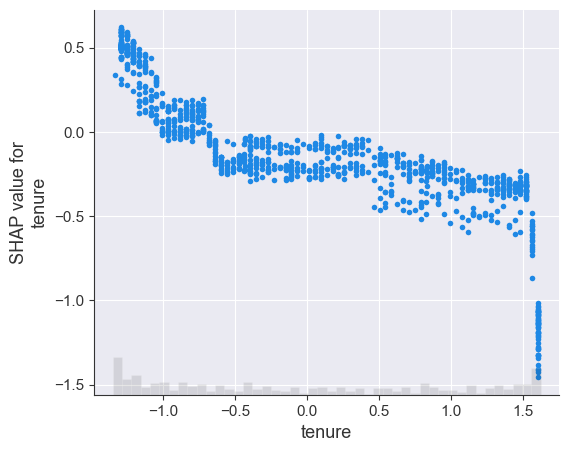

In [38]:
shap.plots.scatter(shap_values[:,"tenure"])

In [39]:
shap.plots.force(shap_values[0:100])

### Model Evaluation

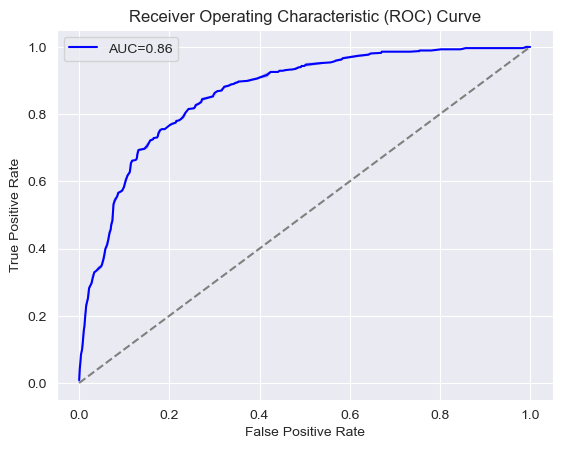

In [40]:
from sklearn.metrics import roc_curve, auc

# get the predicted probabilities of class 1
predicted = xgb_model_best.predict_proba(X_test_processed)[:,1] 

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
sns.set_style("darkgrid")
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
sns.lineplot(data=roc_df, x='fpr', y='tpr', color='blue', label=f'AUC={roc_auc:.2f}')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Text(0.5, 1.0, 'Accuracy Score for XGBoost Classifier: 0.8192999053926207')

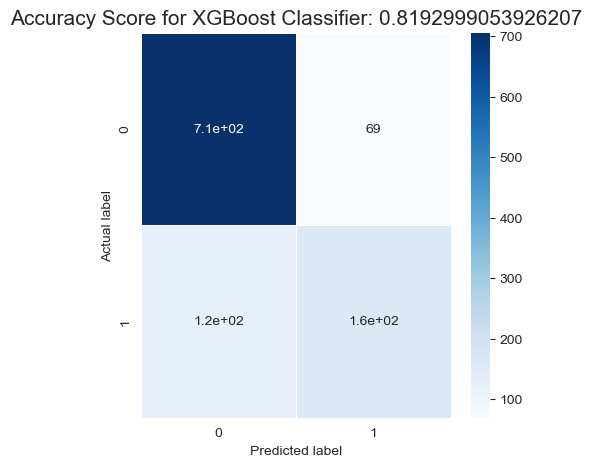

In [41]:
# Display confusion matrix
y_pred = xgb_model_best.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for XGBoost Classifier: {0}'.format(xgb_model_best.score(X_test_processed, y_test))
plt.title(all_sample_title, size = 15)

In [42]:
# Print Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       775
           1       0.70      0.57      0.63       282

    accuracy                           0.82      1057
   macro avg       0.78      0.74      0.75      1057
weighted avg       0.81      0.82      0.81      1057



### Save best model

In [43]:
# # Save model object
# import joblib
# joblib.dump(xgb_model_best, 'best_model.sav')

['best_model.sav']

### Churn Prediction List

In [50]:
# Load the Telco Customer Churn dataset
df = pd.read_csv('Data/Telco-Customer-Churn.csv')

# Convert TotalCharges to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Encode 'Churn'
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

# Separate the numerical and categorical variables
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
            'PaperlessBilling', 'PaymentMethod']

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_df = df[cat_cols]
num_df = df[num_cols]

# Perform one-hot encoding on the categorical variables
encoder = OneHotEncoder(handle_unknown='ignore')
cat_df_enc = pd.DataFrame(encoder.fit_transform(cat_df).toarray(), columns=encoder.get_feature_names(cat_cols))

# Standard scale the numerical variables
scaler = StandardScaler()
num_df_sc = pd.DataFrame(scaler.fit_transform(num_df), columns=num_cols)

# Concatenate the encoded categorical and scaled numerical dataframes
df_processed = pd.concat([cat_df_enc, num_df_sc, df['Churn']], axis=1)

# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(df_processed.drop('Churn', axis=1), df_processed['Churn'], test_size=0.3, random_state=42)

# Sample a portion of the original dataset for test set
test_df = df.sample(frac=0.3, random_state=42)

# Keep a copy of customerID column before dropping it
customerID_test = test_df['customerID']

# Drop customerID column from test set
test_df.drop(['customerID'], axis=1, inplace=True)

# Perform one-hot encoding on the categorical variables
cat_df = test_df[cat_cols]
cat_df_enc = pd.DataFrame(encoder.transform(cat_df).toarray(), columns=encoder.get_feature_names(cat_cols))

# Standard scale the numerical variables
num_df = test_df[num_cols]
num_df_sc = pd.DataFrame(scaler.transform(num_df), columns=num_cols)

# Concatenate the encoded categorical and scaled numerical dataframes
X_test = pd.concat([cat_df_enc, num_df_sc], axis=1)


In [45]:
# Define parameter grid for grid search
param_grid = {
    'max_depth': [3, 4, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 500],
}

# Create an XGBoost classifier
xgb_model = XGBClassifier()

# Perform grid search to find the best hyperparameters
xgb_grid_search = GridSearchCV(xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)
xgb_grid_search.fit(X_train, y_train)


xgb_model_best = XGBClassifier(**xgb_grid_search.best_params_)
xgb_model_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [46]:
evaluate_performance(xgb_model_best, X_val, y_val, "Validation set")

Validation set Accuracy: 0.8041
Validation set Recall: 0.5279
Validation set Precision: 0.6794
Validation set F1 score: 0.5941
Validation set ROC AUC score: 0.7175
[[1396  143]
 [ 271  303]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1539
           1       0.68      0.53      0.59       574

    accuracy                           0.80      2113
   macro avg       0.76      0.72      0.73      2113
weighted avg       0.79      0.80      0.80      2113



(0.804070042593469,
 0.5278745644599303,
 0.679372197309417,
 0.5941176470588235,
 0.7174785427887695)

In [47]:
# Print the best hyperparameters and score
print("Best parameters:", xgb_grid_search.best_params_)
print("Best score:", xgb_grid_search.best_score_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
Best score: 0.8016227180527384


In [48]:
# # Save model object
# import joblib
# joblib.dump(xgb_model_best, 'churn_list.sav')

['churn_list.sav']

In [51]:
model = joblib.load('churn_list.sav')

# Predict probabilities of churn on test set
y_test_prob = model.predict_proba(X_test)[:, 1]

# Create a new dataframe with customer data and predicted probabilities of churn
results_df = pd.concat([customerID_test.reset_index(drop=True), X_test.reset_index(drop=True), pd.Series(y_test_prob, name='ChurnProb')], axis=1)
results_df.head(10)

,customerID,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,ChurnProb
0,1024-GUALD,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,-1.28,-1.33,-0.99,0.69
1,0484-JPBRU,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.35,-1.31,-0.57,0.10
2,3620-EHIMZ,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.80,-1.51,-0.55,0.02
3,6910-HADCM,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,-1.28,0.39,-0.97,0.81
4,8587-XYZSF,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.41,-0.47,0.43,0.02
5,6818-WOBHJ,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.45,0.83,1.70,0.30
6,3082-YVEKW,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,-0.38,0.41,-0.23,0.03
7,4737-AQCPU,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.61,0.24,1.21,0.01
8,4853-RULSV,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.53,1.30,2.19,0.10
9,5766-ZJYBB,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,-1.28,-1.51,-1.00,0.29


In [62]:
results_df[['customerID', 'ChurnProb']].sort_values(by='ChurnProb', ascending=False).head(10)

,customerID,ChurnProb
1109,7216-EWTRS,0.91
1888,5299-SJCZT,0.88
1106,9300-AGZNL,0.88
680,4910-GMJOT,0.88
720,9124-LHCJQ,0.88
417,9282-IZGQK,0.88
936,3068-OMWZA,0.87
1899,2609-IAICY,0.87
1555,4912-PIGUY,0.87
285,5192-EBGOV,0.87


In [76]:
top_10_at_risk = results_df[['customerID', 'ChurnProb']].sort_values(by='ChurnProb', ascending=False).head(10)


fig = px.bar(top_10_at_risk.sort_values('ChurnProb'), x='ChurnProb', y='customerID', orientation='h')

fig.update_layout(
    title='Top 10 Customers at Risk of Churn',
    xaxis_title='Churn Probability',
    yaxis_title='Customer ID',
    width=700,
    height=500
)

fig.show()



In [63]:
# # Save the results to a CSV file
# results_df.to_csv('Data/results.csv', index=False)